In [148]:
import pandas as pd
import matplotlib.pyplot as plt

In [149]:
file_path = "prices.txt"
df = pd.read_csv(file_path)

In [150]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [151]:
df = df.dropna(subset=['Date'])

In [152]:
df = df.sort_values(by='Date')

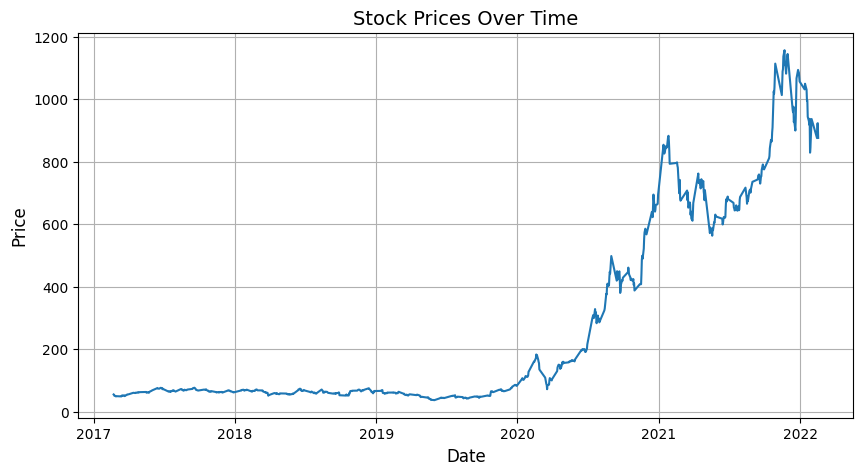

In [153]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Price'])
plt.title('Stock Prices Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True)
plt.show()

In [154]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()
df['Normalized_Price'] = scaler.fit_transform(df[['Price']])

split_index = int(len(df) * 0.8)
train_data = df[:split_index]
test_data = df[split_index:]

def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i+sequence_length])
    return np.array(sequences), np.array(labels)

sequence_length = 5 
train_sequences, train_labels = create_sequences(train_data['Normalized_Price'].values, sequence_length)
test_sequences, test_labels = create_sequences(test_data['Normalized_Price'].values, sequence_length)

print(f"Training Sequences: {train_sequences.shape}, Training Labels: {train_labels.shape}")
print(f"Testing Sequences: {test_sequences.shape}, Testing Labels: {test_labels.shape}")


Training Sequences: (604, 5), Training Labels: (604,)
Testing Sequences: (148, 5), Testing Labels: (148,)


In [155]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(32, activation='relu'),
    Dense(1)
])


In [156]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [157]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5, 64)             16896     
                                                                 
 dropout_1 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [158]:
train_sequences = train_sequences.reshape((train_sequences.shape[0], train_sequences.shape[1], 1))
test_sequences = test_sequences.reshape((test_sequences.shape[0], test_sequences.shape[1], 1))

In [159]:
history = model.fit(train_sequences, train_labels, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20


16/16 [==============================] - 4s 35ms/step - loss: 6.0523e-04 - val_loss: 0.1277
Epoch 2/20
16/16 [==============================] - 0s 12ms/step - loss: 4.1249e-04 - val_loss: 0.1227
Epoch 3/20
16/16 [==============================] - 0s 12ms/step - loss: 3.6212e-04 - val_loss: 0.1123
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 3.1876e-04 - val_loss: 0.0915
Epoch 5/20
16/16 [==============================] - 0s 9ms/step - loss: 2.4233e-04 - val_loss: 0.0657
Epoch 6/20
16/16 [==============================] - 0s 9ms/step - loss: 1.5663e-04 - val_loss: 0.0380
Epoch 7/20
16/16 [==============================] - 0s 9ms/step - loss: 9.8704e-05 - val_loss: 0.0148
Epoch 8/20
16/16 [==============================] - 0s 9ms/step - loss: 7.5517e-05 - val_loss: 0.0082
Epoch 9/20
16/16 [==============================] - 0s 9ms/step - loss: 8.4303e-05 - val_loss: 0.0098
Epoch 10/20
16/16 [==============================] - 0s 9ms/step - loss: 5.8724e-05 - val_

In [160]:
test_loss = model.evaluate(test_sequences, test_labels, verbose=0)
print(f"Test Loss: {test_loss}")

Test Loss: 0.05525747686624527


5/5 [==============================] - 0s 3ms/step
Root Mean Squared Error (RMSE): 263.2392857563143
Mean Absolute Error (MAE): 254.14605483779823
Normalized RMSE (Range): 0.4436044180813159
Normalized RMSE (Mean): 0.33252029392427085
Normalized MAE (Range): 0.42828072732407263
Normalized MAE (Mean): 0.3210338480122981


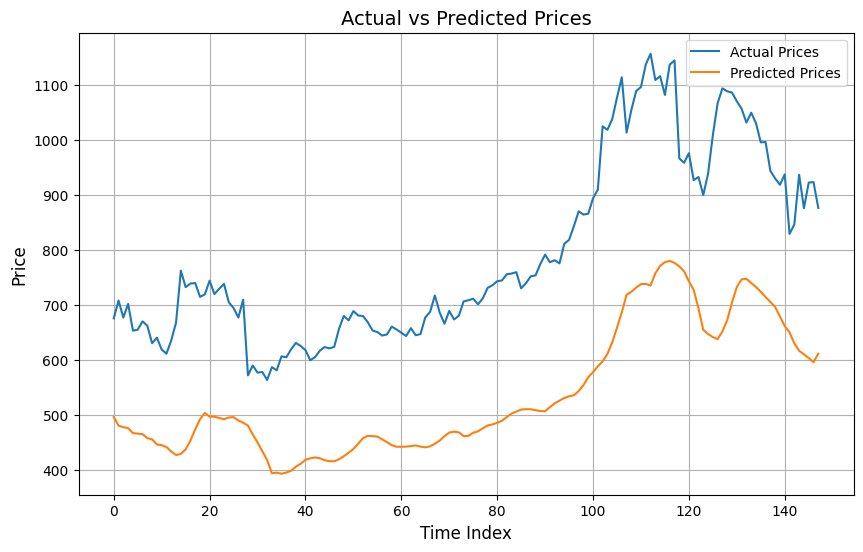

In [161]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicted_prices = model.predict(test_sequences)

predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_labels.reshape(-1, 1))

rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)
mae = mean_absolute_error(actual_prices, predicted_prices)

price_range = actual_prices.max() - actual_prices.min()
price_mean = actual_prices.mean()

nrmse_range = rmse / price_range
nrmse_mean = rmse / price_mean
nmae_range = mae / price_range
nmae_mean = mae / price_mean

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized RMSE (Range): {nrmse_range}")
print(f"Normalized RMSE (Mean): {nrmse_mean}")
print(f"Normalized MAE (Range): {nmae_range}")
print(f"Normalized MAE (Mean): {nmae_mean}")

plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices")
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices")
plt.title('Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [162]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

model_2 = Sequential([
    GRU(64, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    GRU(32, activation='relu'),
    Dense(1)
])

model_2.compile(optimizer='adam', loss='mean_squared_error')
model_2.fit(train_sequences, train_labels, epochs=30, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/30
16/16 [==============================] - 4s 35ms/step - loss: 4.1472e-04 - val_loss: 0.1016
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 2.5634e-04 - val_loss: 0.0790
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 1.7655e-04 - val_loss: 0.0545
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 1.0975e-04 - val_loss: 0.0315
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 6.0711e-05 - val_loss: 0.0191
Epoch 6/30
16/16 [==============================] - 0s 9ms/step - loss: 5.6545e-05 - val_loss: 0.0197
Epoch 7/30
16/16 [==============================] - 0s 9ms/step - loss: 4.2462e-05 - val_loss: 0.0163
Epoch 8/30
16/16 [==============================] - 0s 8ms/step - loss: 4.5347e-05 - val_loss: 0.0152
Epoch 9/30
16/16 [==============================] - 0s 8ms/step - loss: 4.8535e-05 - val_loss: 0.0140
Epoch 10/30
16/16 [==============================] - 0s 9ms/step - loss: 4.5834

In [163]:
test_loss = model_2.evaluate(test_sequences, test_labels, verbose=0)
print(f"Test Loss: {test_loss}")

Test Loss: 0.046668656170368195


5/5 [==============================] - 0s 4ms/step
Root Mean Squared Error (RMSE): 241.9177970927986
Mean Absolute Error (MAE): 231.68407479134555
Normalized RMSE (Range): 0.40767396589204047
Normalized RMSE (Mean): 0.30558727875168584
Normalized MAE (Range): 0.3904283468982845
Normalized MAE (Mean): 0.29266017959989477


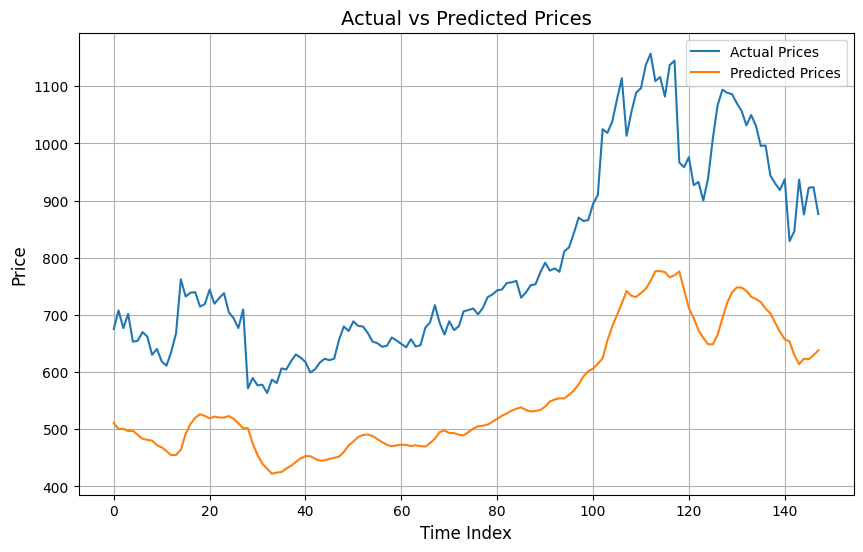

In [164]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicted_prices = model_2.predict(test_sequences)

predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_labels.reshape(-1, 1))

rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)
mae = mean_absolute_error(actual_prices, predicted_prices)

price_range = actual_prices.max() - actual_prices.min()
price_mean = actual_prices.mean()

nrmse_range = rmse / price_range
nrmse_mean = rmse / price_mean
nmae_range = mae / price_range
nmae_mean = mae / price_mean

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized RMSE (Range): {nrmse_range}")
print(f"Normalized RMSE (Mean): {nrmse_mean}")
print(f"Normalized MAE (Range): {nmae_range}")
print(f"Normalized MAE (Mean): {nmae_mean}")

plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices")
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices")
plt.title('Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [165]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

model_3 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu'),
    Dense(1)
])

model_3.compile(optimizer='adam', loss='mean_squared_error')
model_3.fit(train_sequences, train_labels, epochs=20, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/20
16/16 [==============================] - 2s 21ms/step - loss: 5.7606e-04 - val_loss: 0.1078
Epoch 2/20
16/16 [==============================] - 0s 5ms/step - loss: 3.7816e-04 - val_loss: 0.1038
Epoch 3/20
16/16 [==============================] - 0s 5ms/step - loss: 3.0972e-04 - val_loss: 0.0831
Epoch 4/20
16/16 [==============================] - 0s 5ms/step - loss: 2.5207e-04 - val_loss: 0.0623
Epoch 5/20
16/16 [==============================] - 0s 5ms/step - loss: 1.9013e-04 - val_loss: 0.0364
Epoch 6/20
16/16 [==============================] - 0s 5ms/step - loss: 1.2886e-04 - val_loss: 0.0155
Epoch 7/20
16/16 [==============================] - 0s 5ms/step - loss: 8.5662e-05 - val_loss: 0.0042
Epoch 8/20
16/16 [==============================] - 0s 5ms/step - loss: 6.6477e-05 - val_loss: 0.0020
Epoch 9/20
16/16 [==============================] - 0s 5ms/step - loss: 6.3532e-05 - val_loss: 0.0024
Epoch 10/20
16/16 [==============================] - 0s 5ms/step - loss: 6.4429e-

In [166]:
test_loss = model_3.evaluate(test_sequences, test_labels, verbose=0)
print(f"Test Loss: {test_loss}")

Test Loss: 0.003188100876286626


5/5 [==============================] - 0s 2ms/step
Root Mean Squared Error (RMSE): 63.22970497904083
Mean Absolute Error (MAE): 48.9259305254962
Normalized RMSE (Range): 0.10655315524843877
Normalized RMSE (Mean): 0.07987090537785073
Normalized MAE (Range): 0.08244878372729374
Normalized MAE (Mean): 0.06180257157329037


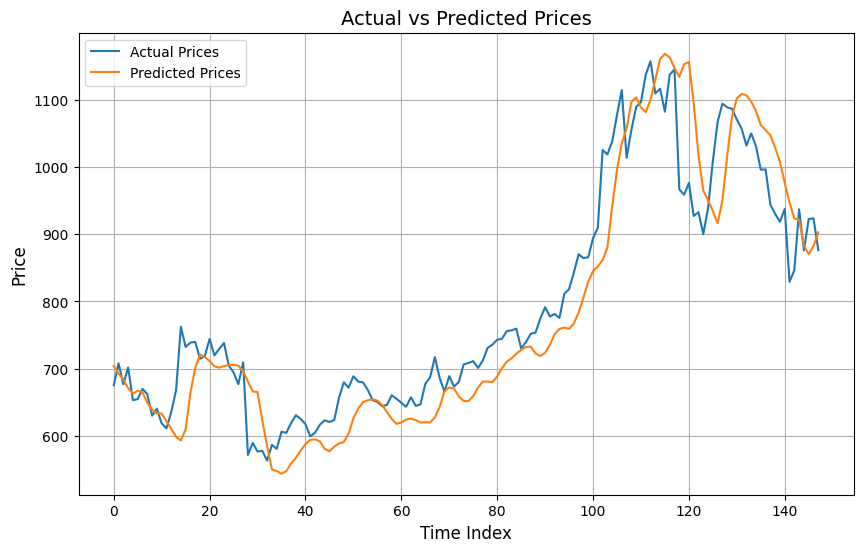

In [167]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

predicted_prices = model_3.predict(test_sequences)

predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_labels.reshape(-1, 1))

rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)
mae = mean_absolute_error(actual_prices, predicted_prices)

price_range = actual_prices.max() - actual_prices.min()
price_mean = actual_prices.mean()

nrmse_range = rmse / price_range
nrmse_mean = rmse / price_mean
nmae_range = mae / price_range
nmae_mean = mae / price_mean

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized RMSE (Range): {nrmse_range}")
print(f"Normalized RMSE (Mean): {nrmse_mean}")
print(f"Normalized MAE (Range): {nmae_range}")
print(f"Normalized MAE (Mean): {nmae_mean}")

plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices")
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices")
plt.title('Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [172]:
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', 32, 128, step=32), activation='relu', input_shape=(sequence_length, 1)))
    model.add(Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    directory='hyperparam_tuning',
    project_name='stock_price_predictor'
)

tuner.search(train_sequences, train_labels, epochs=20, validation_split=0.2)


Trial 18 Complete [00h 00m 10s]
val_loss: 0.0064542097970843315

Best val_loss So Far: 0.0018047579796984792
Total elapsed time: 00h 03m 19s


In [173]:
best_model = tuner.get_best_models(num_models=1)[0]

5/5 [==============================] - 0s 5ms/step - loss: 0.0026
Test Loss (MSE): 0.00255799968726933
5/5 [==============================] - 0s 4ms/step
Root Mean Squared Error (RMSE): 56.637681477268075
Mean Absolute Error (MAE): 44.09308932733319
Normalized RMSE (Range): 0.09544443816967682
Normalized RMSE (Mean): 0.07154395073630707
Normalized MAE (Range): 0.07430459772089676
Normalized MAE (Mean): 0.05569779214766111


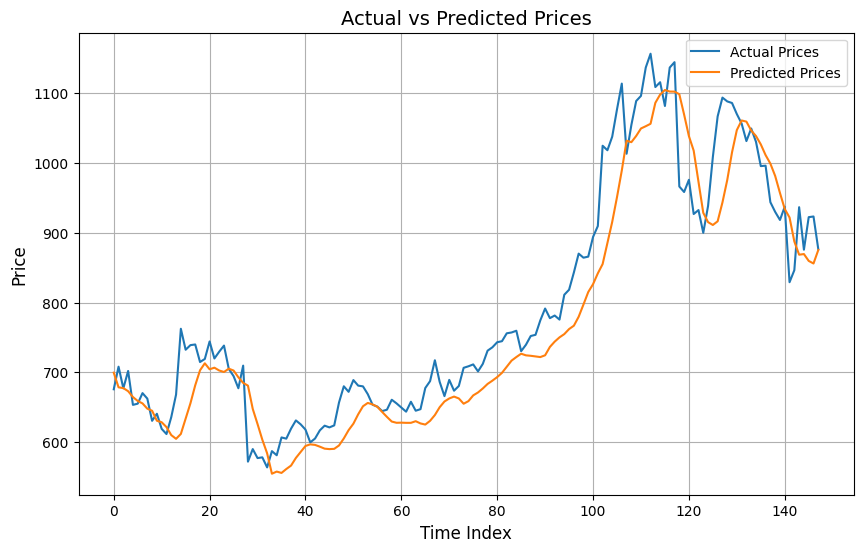

In [174]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_loss = best_model.evaluate(test_sequences, test_labels, verbose=1)
print(f"Test Loss (MSE): {test_loss}")

predicted_prices = best_model.predict(test_sequences)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_labels.reshape(-1, 1))

rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)
mae = mean_absolute_error(actual_prices, predicted_prices)

price_range = actual_prices.max() - actual_prices.min()
price_mean = actual_prices.mean()

nrmse_range = rmse / price_range
nrmse_mean = rmse / price_mean
nmae_range = mae / price_range
nmae_mean = mae / price_mean

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized RMSE (Range): {nrmse_range}")
print(f"Normalized RMSE (Mean): {nrmse_mean}")
print(f"Normalized MAE (Range): {nmae_range}")
print(f"Normalized MAE (Mean): {nmae_mean}")

plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices")
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices")
plt.title('Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [175]:
best_model.save('final_stock_model.h5')

c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [183]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
import keras_tuner as kt

# Step 1: Define the build_model function
def build_model(hp):
    model = Sequential()
    
    # Conv1D layer
    kernel_size = hp.Int('kernel_size', min_value=1, max_value=min(sequence_length - 1, 5), step=1)
    model.add(Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=kernel_size,
        activation='relu',
        input_shape=(sequence_length, 1)
    ))
    
    # MaxPooling1D layer
    pool_size = hp.Int('pool_size', min_value=2, max_value=min(sequence_length - kernel_size, 3), step=1)
    model.add(MaxPooling1D(pool_size=pool_size))
    
    # LSTM layer
    model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), activation='relu'))
    
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    
    model.add(Dense(1))
    
    model.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,  # Number of hyperparameter combinations to try
    directory='conv1d_lstm_tuning',
    project_name='stock_price_tuning'
)

# Step 3: Run the search
tuner.search(
    train_sequences, train_labels,
    epochs=20,
    validation_split=0.2,
    verbose=1
)

# Step 4: Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.values)


Trial 20 Complete [00h 00m 08s]
val_loss: 0.0026664892211556435

Best val_loss So Far: 0.0015071341767907143
Total elapsed time: 00h 02m 30s
Best Hyperparameters:
{'kernel_size': 3, 'filters': 64, 'pool_size': 3, 'lstm_units': 64, 'dropout': 0.5}


5/5 [==============================] - 0s 3ms/step - loss: 0.0025
Test Loss (MSE): 0.0025245214346796274
5/5 [==============================] - 0s 2ms/step
Root Mean Squared Error (RMSE): 56.26581990020871
Mean Absolute Error (MAE): 42.934714234243025
Normalized RMSE (Range): 0.09481778611801107
Normalized RMSE (Mean): 0.0710742202378837
Normalized MAE (Range): 0.07235253229261625
Normalized MAE (Mean): 0.05423454844783787


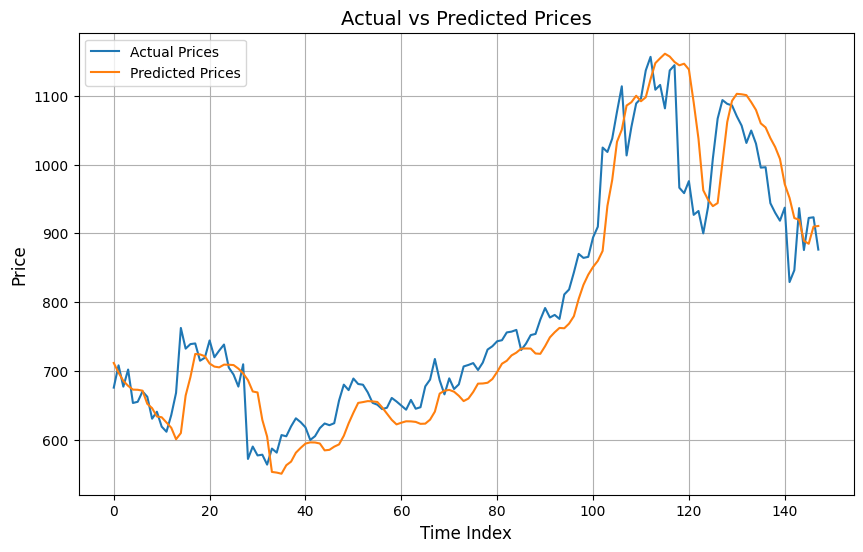

In [184]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_loss = best_model.evaluate(test_sequences, test_labels, verbose=1)
print(f"Test Loss (MSE): {test_loss}")

predicted_prices = best_model.predict(test_sequences)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_labels.reshape(-1, 1))

rmse = mean_squared_error(actual_prices, predicted_prices, squared=False)
mae = mean_absolute_error(actual_prices, predicted_prices)

price_range = actual_prices.max() - actual_prices.min()
price_mean = actual_prices.mean()

nrmse_range = rmse / price_range
nrmse_mean = rmse / price_mean
nmae_range = mae / price_range
nmae_mean = mae / price_mean

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized RMSE (Range): {nrmse_range}")
print(f"Normalized RMSE (Mean): {nrmse_mean}")
print(f"Normalized MAE (Range): {nmae_range}")
print(f"Normalized MAE (Mean): {nmae_mean}")

plt.figure(figsize=(10, 6))
plt.plot(range(len(actual_prices)), actual_prices, label="Actual Prices")
plt.plot(range(len(predicted_prices)), predicted_prices, label="Predicted Prices")
plt.title('Actual vs Predicted Prices', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid()
plt.show()


In [185]:
best_model.save('conv1d_lstm_best_stock_price_predictor.h5')


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
